# Prediction of bookings based on user behavior
Data Scientist – User Profiling, Hotel Search

- Author: Kai Chen
- Date: Apr, 2018

## Situation:

A search session describes a user’s journey to find his ideal hotel, by including all his interactions. Given user search sessions, we are interested in predicting the outcome of these sessions based on the users’ interactions; as well determining which of these interactions have the highest importance for this estimation.

## Data:

We provide two kinds of data sets:

- anonymized user logs generated by usage on our website (user actions); and,
- booking outcome per session with contextual information (bookings).


Both types of datasets are split by the same timestamp into train and target sets. The target set contains the same information as the training set, except the outcome (i.e. has_booking). More information is provided in README.md (You can find this in the resources section).


## Task:

The task is to train a machine learning model to estimate if a booking occurred – the training and target sets have been provided for you. We expect binary predictions for the target sessions, which will be evaluated by Matthews Correlation Coefficient (MCC) using the ground truth dataset on our side. You can have as many submissions as you would like to improve your solution.


## Additional questions:

- What makes the classification problem difficult in this task? How do you handle that?
- Evaluate and compare at least 3 classification methods for this task.
- Propose at least 3 features that are significant to predict bookings?
- We can spot a very significant action type. What might this action refer to?



There are 3 types of data: Bookings, User actions, Example.

## Data: Bookings
- Description: List of sessions, each with: session-related contextual data, and whether at least one booking was made
- Files:
	- case_study_bookings_train.csv: Training sessions for bookings
	- case_study_bookings_target.csv: Target sessions to predict bookings
- Rows: Each row represents a session with session context and the outcome of this session
- Columns:
	- ymd: Date of the session in format 'yyMMdd'
	- user_id: Anonymized cookie id of the visitor
	- session_id: Anonymized id of the session
	- referer_code: Encoded category of the referer to the website
	- is_app: If the session was made using the trivago app
	- agent_id: Encoded type of the browser
	- traffic_type: A categorization of the type of the traffic
	- has_booking: 1 if at least one booking was made during the session (excluded from the target set)
    
## Data: User Actions
- Description: Sequence of various type of user actions generated during the usage of the website.
- Files
	- case_study_actions_train.csv: Training set of user actions
	- case_study_actions_target.csv: User actions in the target sessions
- Rows: Each row represents one action from/to the user
- Columns:
	- ymd: Date of the action in format 'yyMMdd'
	- user_id: Anonymized cookie id of the visitor
	- session_id: Anonymized id of the session
	- action_id: Type of the action
	- reference: Object of the action. - We note that action_ids with big set of reference values (e.g. action id '2116') are typically related to the content (e.g hotels, destinations or keywords); while action_ids with small reference set (e.g. action id '2351') are more related a function of the website (e.g. sorting order, room type, filters, etc.)
	- step: The number identifying the action in the session
	
## Data: Example Solution
- Description: List of predictions for bookings in the target sessions
- File: case_study_bookings_target_prediction_example.csv
- Rows: Each row represent a target session for which a prediction should be given
- Columns:
	- session_id: Anonymized id of the session
	- has_booking: Random binary predictions for bookings

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore", DeprecationWarning)

import numpy as np
import pandas as pd
from datetime import datetime
import operator
from collections import OrderedDict
import time
import csv

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.externals import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.metrics import accuracy_score

import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm as lgb

import catboost
from catboost import CatBoostClassifier

np.random.seed(42)

In [11]:
# ---
# Define file paths
TRAIN_BOOKING_FILE_PATH = 'data/case_study_bookings_train.csv'    # training sessions for bookings
TARGET_BOOKING_FILE_PATH = 'data/case_study_bookings_target.csv'  # target sessions to predict bookings

TRAIN_ACTION_FILE_PATH = 'data/case_study_actions_train.csv'       # training set of user actions
TARGET_ACTION_FILE_PATH = 'data/case_study_actions_target.csv'     # user actions in the target sessions

## Step 1: read and explore the data

In [79]:
"""
train booking data
- ymd:           Date of the session in format 'yyMMdd'
- user_id:       Anonymized cookie id of the visitor
- session_id:    Anonymized id of the session
- referer_code:  Encoded category of the referer to the website
- is_app:        If the session was made using the trivago app
- agent_id:      Encoded type of the browser
- traffic_type:  A categorization of the type of the traffic
- has_booking:   1 if at least one booking was made during the session (excluded from the target set)
"""

train_booking_df = pd.read_csv(TRAIN_BOOKING_FILE_PATH, sep='\t')
train_booking_df['ymd'] = pd.to_datetime(train_booking_df['ymd'].astype('str'))

print('\ntrain booking')
print(train_booking_df.columns)
print(train_booking_df.describe())

print('\nmax')
print(train_booking_df.max())

print('\nmin')
print(train_booking_df.min())

display(train_booking_df.head(5))


train booking
Index(['ymd', 'user_id', 'session_id', 'referer_code', 'is_app', 'agent_id',
       'traffic_type', 'has_booking'],
      dtype='object')
            user_id    session_id   referer_code         is_app  \
count  3.076770e+05  3.076770e+05  307677.000000  307677.000000   
mean   4.622586e+18  4.609514e+18      22.857828       0.073571   
std    2.665868e+18  2.662771e+18      40.179017       0.261071   
min    3.883091e+14  1.097161e+14       0.000000       0.000000   
25%    2.312274e+18  2.303980e+18       0.000000       0.000000   
50%    4.635855e+18  4.612005e+18       1.000000       0.000000   
75%    6.932941e+18  6.912236e+18      15.000000       0.000000   
max    9.223267e+18  9.223359e+18      99.000000       1.000000   

            agent_id   traffic_type    has_booking  
count  307677.000000  307677.000000  307677.000000  
mean        7.424809       2.686174       0.063856  
std         3.713358       1.906000       0.244497  
min         0.000000       1.00

,ymd,user_id,session_id,referer_code,is_app,agent_id,traffic_type,has_booking
0,2017-04-23,388309106223940,3052767322364990735,0,0,2,1,0
1,2017-04-10,452426828488840,1022778951418899936,0,0,10,2,0
2,2017-04-15,452426828488840,4191504489082712531,0,0,10,2,0
3,2017-04-06,819438352219100,4560227804862289210,1,0,1,1,0
4,2017-04-07,1113732603712480,4115013282086590434,0,0,9,2,0


In [80]:
"""
target booking data
- ymd:          Date of the session in format 'yyMMdd'
- user_id:      Anonymized cookie id of the visitor
- session_id:   Anonymized id of the session
- referer_code: Encoded category of the referer to the website
- is_app:       If the session was made using the trivago app
- agent_id:     Encoded type of the browser
- traffic_type: A categorization of the type of the traffic
"""

target_booking_df = pd.read_csv(TARGET_BOOKING_FILE_PATH, sep='\t')
target_booking_df['ymd'] = pd.to_datetime(target_booking_df['ymd'].astype('str'))

print('\ntarget booking')
print(target_booking_df.columns)

print('\nmin')
print(target_booking_df.min())

print('\nmax')
print(target_booking_df.max())

display(target_booking_df.head(5))


target booking
Index(['ymd', 'user_id', 'session_id', 'referer_code', 'is_app', 'agent_id',
       'traffic_type'],
      dtype='object')

min
ymd             2017-04-28 00:00:00
user_id            1607565913119260
session_id          288684655403597
referer_code                      0
is_app                            0
agent_id                          0
traffic_type                      1
dtype: object

max
ymd             2017-04-30 00:00:00
user_id         9223057583881579293
session_id      9223351684048666531
referer_code                     99
is_app                            1
agent_id                         14
traffic_type                     10
dtype: object


,ymd,user_id,session_id,referer_code,is_app,agent_id,traffic_type
0,2017-04-30,1607565913119260,4175939893794521966,0,0,14,6
1,2017-04-30,1607565913119260,9175174925268392332,0,0,14,1
2,2017-04-30,2669945826129900,5361965966177226983,0,0,6,6
3,2017-04-30,6247954936827660,7996347049132178025,0,0,13,2
4,2017-04-30,6447705595982360,6061498713259551906,99,0,1,6


In [81]:
# get number of users and sessions in the train booking data

train_user_id_list = train_booking_df['user_id'].unique()
train_session_id_list = train_booking_df['session_id'].unique()

print('number of users (train booking data): {}'.format(len(train_user_id_list)))
print('number of sessions (tarin booking data): {}'.format(len(train_session_id_list)))
print('dataframe size (train booking data): ')
print(train_booking_df.shape)

number of users (train booking data): 181860
number of sessions (tarin booking data): 307677
dataframe size (train booking data): 
(307677, 8)


In [82]:
# get number of users and sessions in the target booking data

target_user_id_list = target_booking_df['user_id'].unique()
target_session_id_list = target_booking_df['session_id'].unique()

print('number of users (target booking data): {}'.format(len(target_user_id_list)))
print('number of sessions (target booking data): {}'.format(len(target_session_id_list)))
print('dataframe size (target booking data): ')
print(target_booking_df.shape)

number of users (target booking data): 23402
number of sessions (target booking data): 30128
dataframe size (target booking data): 
(30128, 7)


In [83]:
"""
train action data
- ymd:        Date of the action in format 'yyMMdd'
- user_id:    Anonymized cookie id of the visitor
- session_id: Anonymized id of the session
- action_id:  Type of the action
- reference:  Object of the action. - We note that action_ids with big set of reference values (e.g. action id '2116') are typically related to the content (e.g hotels, destinations or keywords); while action_ids with small reference set (e.g. action id '2351') are more related a function of the website (e.g. sorting order, room type, filters, etc.)
- step:       The number identifying the action in the session
"""
train_action_df = pd.read_csv(TRAIN_ACTION_FILE_PATH, sep='\t')
train_action_df['ymd'] = pd.to_datetime(train_action_df['ymd'].astype('str'))
train_action_df['step'] = train_action_df['step'].astype('int')

print('train action')
print(train_action_df.columns)
print(train_action_df.describe())

print('min')
print(train_action_df.min())

print('max')
print(train_action_df.max())


display(train_action_df.head(5))

train action
Index(['ymd', 'user_id', 'session_id', 'action_id', 'reference', 'step'], dtype='object')
            user_id    session_id     action_id     reference          step
count  5.862863e+06  5.862863e+06  5.862863e+06  5.862863e+06  5.862863e+06
mean   4.612543e+18  4.607893e+18  2.813712e+03  4.898678e+05  5.464623e+01
std    2.657161e+18  2.656793e+18  1.635718e+03  2.865848e+06  1.319077e+02
min    3.883091e+14  1.097161e+14  2.900000e+01 -1.000000e+00  1.000000e+00
25%    2.307275e+18  2.310688e+18  2.119000e+03  1.000000e+00  6.000000e+00
50%    4.624574e+18  4.606641e+18  2.146000e+03  3.164400e+04  1.800000e+01
75%    6.897454e+18  6.892497e+18  2.501000e+03  1.297190e+05  4.800000e+01
max    9.223267e+18  9.223359e+18  8.091000e+03  6.814322e+08  3.133000e+03
min
ymd           2017-04-01 00:00:00
user_id           388309106223940
session_id        109716089376632
action_id                      29
reference                      -1
step                            1
dtype

,ymd,user_id,session_id,action_id,reference,step
0,2017-04-23,388309106223940,3052767322364990735,8001,1323836,1
1,2017-04-10,452426828488840,1022778951418899936,2116,929835,1
2,2017-04-10,452426828488840,1022778951418899936,6999,0,2
3,2017-04-10,452426828488840,1022778951418899936,2116,929835,3
4,2017-04-10,452426828488840,1022778951418899936,2503,1,4


In [84]:
# get number of users and sessions in the action list

train_user_id_action_list = train_action_df['user_id'].unique()
train_session_id_action_list = train_action_df['session_id'].unique()

print('number of users (train action data): {}'.format(len(train_user_id_action_list)))
print('number of sessions (train action data): {}'.format(len(train_session_id_action_list)))
print('dataframe size (train booking data): ')
print(train_action_df.shape)

number of users (train action data): 181730
number of sessions (train action data): 306106
dataframe size (train booking data): 
(5862863, 6)


In [85]:
print(len(set(train_user_id_list) - set(train_user_id_action_list)))

print(len(set(train_user_id_action_list) - set(train_user_id_list)))

# It shows that all the users who have an action can be found in the booking data.
# It also shows that 130 users in the traing data do not have actions.

130
0


In [86]:
# get the id of the users who do not have an action information

train_user_id_no_action_list = []
for user_id in train_user_id_list:
    if not user_id in train_user_id_action_list:
        train_user_id_no_action_list.append(user_id)
    
print(len(train_user_id_no_action_list))

130


In [87]:
# get the lists of number of bookings for the users who have action information and the users who do not have action information

nb_bookings_action = []
nb_bookings_no_action = []

for user_id in train_user_id_list:
    nb_bookings = np.sum(train_booking_df[train_booking_df['user_id'] == user_id]['has_booking'].values)
    nb_bookings_action.append(nb_bookings)

for user_id in train_user_id_no_action_list:
    nb_bookings = np.sum(train_booking_df[train_booking_df['user_id'] == user_id]['has_booking'].values)
    nb_bookings_no_action.append(nb_bookings)
    
    
print('\nnumber of users (with action): {}'.format(len(train_user_id_list))) 
print('number of users (without action): {}'.format(len(train_user_id_no_action_list))) 
print('number of bookings (with action): {}'.format(np.sum(nb_bookings_action)))
print('number of bookings (without action): {}'.format(np.sum(nb_bookings_no_action)))
print('mean number of bookings (with action): {}'.format(np.mean(nb_bookings_action)))
print('mean number of bookings (without action): {}'.format(np.mean(nb_bookings_no_action)))
print('standard deviation number of bookings (with action): {}'.format(np.std(nb_bookings_action)))
print('standard deviation number of bookings (without action): {}'.format(np.std(nb_bookings_no_action)))
        
# This shows that users without action are more likely to book a hotel.


number of users (with action): 181860
number of users (without action): 130
number of bookings (with action): 19647
number of bookings (without action): 103
mean number of bookings (with action): 0.1080336522599802
mean number of bookings (without action): 0.7923076923076923
standard deviation number of bookings (with action): 0.3341389925584934
standard deviation number of bookings (without action): 0.829236477788257


In [88]:
"""
target action data
- ymd:        Date of the action in format 'yyMMdd'
- user_id:    Anonymized cookie id of the visitor
- session_id: Anonymized id of the session
- action_id:  Type of the action
- reference:  Object of the action. - We note that action_ids with big set of reference values (e.g. action id '2116') are typically related to the content (e.g hotels, destinations or keywords); while action_ids with small reference set (e.g. action id '2351') are more related a function of the website (e.g. sorting order, room type, filters, etc.)
- step:       The number identifying the action in the session
"""

target_action_df = pd.read_csv(TARGET_ACTION_FILE_PATH, sep='\t')
target_action_df['ymd'] = pd.to_datetime(target_action_df['ymd'].astype('str'))

print('target action')
print(target_action_df.columns)
print(target_action_df.describe())
print(target_action_df.head(5))

target action
Index(['ymd', 'user_id', 'session_id', 'action_id', 'reference', 'step'], dtype='object')
            user_id    session_id      action_id     reference           step
count  5.751520e+05  5.751520e+05  575152.000000  5.751520e+05  575152.000000
mean   4.620294e+18  4.648837e+18    2796.277468  4.831560e+05      60.934040
std    2.669707e+18  2.671616e+18    1600.930226  2.488881e+06     150.311639
min    1.607566e+15  2.886847e+14      29.000000 -1.000000e+00       1.000000
25%    2.263261e+18  2.313074e+18    2119.000000  1.000000e+00       6.000000
50%    4.624574e+18  4.646138e+18    2146.000000  3.146400e+04      18.000000
75%    6.952373e+18  7.010441e+18    2503.000000  1.316782e+05      50.000000
max    9.223058e+18  9.223352e+18    8020.000000  7.055946e+08    2299.000000
         ymd           user_id           session_id  action_id  reference  \
0 2017-04-30  1607565913119260  4175939893794521966       2113      60196   
1 2017-04-30  1607565913119260  41759398

In [89]:
target_user_id_action_list = target_action_df['user_id'].unique()
target_session_id_action_list = target_action_df['session_id'].unique()

print('number of users (target action data): {}'.format(len(target_user_id_action_list)))
print('number of sessions (target action data): {}'.format(len(target_session_id_action_list)))
print('dataframe size (target booking data): ')
print(target_action_df.shape)

number of users (target action data): 23314
number of sessions (target action data): 29957
dataframe size (target booking data): 
(575152, 6)


In [90]:
# replace the NAN values by a specific value

NA_ACTION_ID = -10
NA_REFERENCE_ID = -10
NA_STEP = 0

In [91]:
train_user_df =  pd.merge(train_booking_df, train_action_df, on=['ymd', 'user_id', 'session_id'], how='left')

print('min action id: {}'.format(np.min(list(train_action_df['action_id'].values))))
print('max action id: {}'.format(np.max(list(train_action_df['action_id'].values))))

print('min reference id: {}'.format(np.min(list(train_action_df['reference'].values))))
print('max reference id: {}'.format(np.max(list(train_action_df['reference'].values))))

print('min step: {}'.format(np.min(list(train_action_df['step'].values))))
print('max step: {}'.format(np.max(list(train_action_df['step'].values))))

print('number of rows where action id is NaN: {}'.format(train_user_df['action_id'].isnull().sum()))
print('number of rows where reference is NaN: {}'.format(train_user_df['reference'].isnull().sum()))
print('number of rows where step is NaN: {}'.format(train_user_df['step'].isnull().sum()))
#print(train_user_df[train_user_df['action_id'].isnull() | train_user_df['reference'].isnull()])

train_user_df['action_id'].fillna(NA_ACTION_ID, inplace=True)
train_user_df['reference'].fillna(NA_REFERENCE_ID, inplace=True)
train_user_df['step'].fillna(NA_STEP, inplace=True)

print('number of rows where action id is NaN: {}'.format(train_user_df['action_id'].isnull().sum()))
print('number of rows where reference is NaN: {}'.format(train_user_df['reference'].isnull().sum()))
print('number of rows where step is NaN: {}'.format(train_user_df['step'].isnull().sum()))
#print(train_user_df[train_user_df['action_id'].isnull() | train_user_df['reference'].isnull()])

print('min action id: {}'.format(np.min(list(train_user_df['action_id'].values))))
print('max action id: {}'.format(np.max(list(train_user_df['action_id'].values))))

print('min reference id: {}'.format(np.min(list(train_user_df['reference'].values))))
print('max reference id: {}'.format(np.max(list(train_user_df['reference'].values))))

print('min step: {}'.format(np.min(list(train_user_df['step'].values))))
print('max step: {}'.format(np.max(list(train_user_df['step'].values))))


train_user_df['action_id'] = train_user_df['action_id'].astype('int')
train_user_df['reference'] = train_user_df['reference'].astype('int')
train_user_df['step'] = train_user_df['step'].astype('int')

print(train_user_df.columns)
print(train_user_df.describe())
print('train user df shape: ')
print(train_user_df.shape)
display(train_user_df.head(5))
print('number of users: {}'.format(len(train_user_df['user_id'].unique())))

min action id: 29
max action id: 8091
min reference id: -1
max reference id: 681432202
min step: 1
max step: 3133
number of rows where action id is NaN: 1571
number of rows where reference is NaN: 1571
number of rows where step is NaN: 1571
number of rows where action id is NaN: 0
number of rows where reference is NaN: 0
number of rows where step is NaN: 0
min action id: -10.0
max action id: 8091.0
min reference id: -10.0
max reference id: 681432202.0
min step: 0.0
max step: 3133.0
Index(['ymd', 'user_id', 'session_id', 'referer_code', 'is_app', 'agent_id',
       'traffic_type', 'has_booking', 'action_id', 'reference', 'step'],
      dtype='object')
            user_id    session_id  referer_code        is_app      agent_id  \
count  5.864434e+06  5.864434e+06  5.864434e+06  5.864434e+06  5.864434e+06   
mean   4.612515e+18  4.607873e+18  1.050245e+01  1.247070e-01  7.267086e+00   
std    2.657178e+18  2.656793e+18  2.855244e+01  3.303864e-01  3.802190e+00   
min    3.883091e+14  1.09

,ymd,user_id,session_id,referer_code,is_app,agent_id,traffic_type,has_booking,action_id,reference,step
0,2017-04-23,388309106223940,3052767322364990735,0,0,2,1,0,8001,1323836,1
1,2017-04-10,452426828488840,1022778951418899936,0,0,10,2,0,2116,929835,1
2,2017-04-10,452426828488840,1022778951418899936,0,0,10,2,0,6999,0,2
3,2017-04-10,452426828488840,1022778951418899936,0,0,10,2,0,2116,929835,3
4,2017-04-10,452426828488840,1022778951418899936,0,0,10,2,0,2503,1,4


number of users: 181860


In [92]:
print('ymd (train)')
print(train_user_df['ymd'].unique())

ymd (train)
['2017-04-23T00:00:00.000000000' '2017-04-10T00:00:00.000000000'
 '2017-04-15T00:00:00.000000000' '2017-04-06T00:00:00.000000000'
 '2017-04-07T00:00:00.000000000' '2017-04-19T00:00:00.000000000'
 '2017-04-16T00:00:00.000000000' '2017-04-17T00:00:00.000000000'
 '2017-04-04T00:00:00.000000000' '2017-04-13T00:00:00.000000000'
 '2017-04-08T00:00:00.000000000' '2017-04-25T00:00:00.000000000'
 '2017-04-09T00:00:00.000000000' '2017-04-12T00:00:00.000000000'
 '2017-04-03T00:00:00.000000000' '2017-04-24T00:00:00.000000000'
 '2017-04-27T00:00:00.000000000' '2017-04-26T00:00:00.000000000'
 '2017-04-02T00:00:00.000000000' '2017-04-14T00:00:00.000000000'
 '2017-04-05T00:00:00.000000000' '2017-04-22T00:00:00.000000000'
 '2017-04-20T00:00:00.000000000' '2017-04-11T00:00:00.000000000'
 '2017-04-18T00:00:00.000000000' '2017-04-21T00:00:00.000000000'
 '2017-04-01T00:00:00.000000000']


In [93]:
target_user_df =  pd.merge(target_booking_df, target_action_df, on=['ymd', 'user_id', 'session_id'], how='left')

print('number of rows where action id (target) is NaN: {}'.format(target_user_df['action_id'].isnull().sum()))
print('number of rows where reference (target) is NaN: {}'.format(target_user_df['reference'].isnull().sum()))
print('number of rows where step is (target) NaN: {}'.format(target_user_df['step'].isnull().sum()))
#print(target_user_df[train_user_df['action_id'].isnull() | target_user_df['reference'].isnull()])

target_user_df['action_id'].fillna(NA_ACTION_ID, inplace=True)
target_user_df['reference'].fillna(NA_REFERENCE_ID, inplace=True)
target_user_df['step'].fillna(NA_STEP, inplace=True)

print('number of rows where action id (target) is NaN: {}'.format(target_user_df['action_id'].isnull().sum()))
print('number of rows where reference (target) is NaN: {}'.format(target_user_df['reference'].isnull().sum()))
print('number of rows where step is (target) NaN: {}'.format(target_user_df['step'].isnull().sum()))
#print(train_user_df[train_user_df['action_id'].isnull() | train_user_df['reference'].isnull()])

target_user_df['action_id'] = target_user_df['action_id'].astype('int')
target_user_df['reference'] = target_user_df['reference'].astype('int')
target_user_df['step'] = target_user_df['step'].astype('int')

print(target_user_df.columns)
print(target_user_df.describe())
print('target user df shape')
print(target_user_df.shape)
display(target_user_df.head(5))
print('number of users (target): {}'.format(len(target_user_df['user_id'].unique())))

number of rows where action id (target) is NaN: 171
number of rows where reference (target) is NaN: 171
number of rows where step is (target) NaN: 171
number of rows where action id (target) is NaN: 0
number of rows where reference (target) is NaN: 0
number of rows where step is (target) NaN: 0
Index(['ymd', 'user_id', 'session_id', 'referer_code', 'is_app', 'agent_id',
       'traffic_type', 'action_id', 'reference', 'step'],
      dtype='object')
            user_id    session_id   referer_code         is_app  \
count  5.753230e+05  5.753230e+05  575323.000000  575323.000000   
mean   4.620225e+18  4.648770e+18      11.004495       0.135762   
std    2.669715e+18  2.671621e+18      29.310329       0.342536   
min    1.607566e+15  2.886847e+14       0.000000       0.000000   
25%    2.263261e+18  2.313074e+18       0.000000       0.000000   
50%    4.624574e+18  4.646138e+18       1.000000       0.000000   
75%    6.952373e+18  7.010441e+18       1.000000       0.000000   
max    9.22

,ymd,user_id,session_id,referer_code,is_app,agent_id,traffic_type,action_id,reference,step
0,2017-04-30,1607565913119260,4175939893794521966,0,0,14,6,2113,60196,1
1,2017-04-30,1607565913119260,4175939893794521966,0,0,14,6,6999,0,2
2,2017-04-30,1607565913119260,4175939893794521966,0,0,14,6,2113,60196,3
3,2017-04-30,1607565913119260,9175174925268392332,0,0,14,1,2100,0,1
4,2017-04-30,1607565913119260,9175174925268392332,0,0,14,1,6999,0,2


number of users (target): 23402


In [94]:
print('ymd (target)')
print(target_user_df['ymd'].unique())

ymd (target)
['2017-04-30T00:00:00.000000000' '2017-04-28T00:00:00.000000000'
 '2017-04-29T00:00:00.000000000']


In [95]:
train_user_id_list = train_user_df['user_id'].unique()

print('number of users (train): {}'.format(len(train_user_id_list)))

target_user_id_list = target_user_df['user_id'].unique()

print('number of users (target): {}'.format(len(target_user_id_list)))


print('\nnumber of different users between train user id and target user id')
print(len(set(train_user_id_list) - set(target_user_id_list)))
print(len(set(target_user_id_list) - set(train_user_id_list)))

intersect_user_id_list = []
for user_id in target_user_id_list:
    if user_id in train_user_id_list:
        intersect_user_id_list.append(user_id)
    
print('number of users in target data can be found in train data: {}'.format(len(intersect_user_id_list)))

# Although I find that 8062/23402 users in the target set can be found in the train set, 
# I doubt taking 'user_id' as a feature may overfit the model.

number of users (train): 181860
number of users (target): 23402

number of different users between train user id and target user id
173798
15340
number of users in target data can be found in train data: 8062


In [96]:
print('correlation')

corr_score = train_user_df['user_id'].corr(train_user_df['has_booking'])
print('corr score of user_id and has_booking {}'.format(corr_score))

corr_score = train_user_df['referer_code'].corr(train_user_df['has_booking'])
print('corr score of referer_code and has_booking {}'.format(corr_score))

corr_score = train_user_df['is_app'].corr(train_user_df['has_booking'])
print('corr score of is_app and has_booking {}'.format(corr_score))

corr_score = train_user_df['agent_id'].corr(train_user_df['has_booking'])
print('corr score of agent_id and has_booking {}'.format(corr_score))

corr_score = train_user_df['traffic_type'].corr(train_user_df['has_booking'])
print('corr score of traffic_type and has_booking {}'.format(corr_score))

corr_score = train_user_df['action_id'].corr(train_user_df['has_booking'])
print('corr score of action_id and has_booking {}'.format(corr_score))

corr_score = train_user_df['reference'].corr(train_user_df['has_booking'])
print('corr score of reference and has_booking {}'.format(corr_score))

corr_score = train_user_df['step'].corr(train_user_df['has_booking'])
print('corr score of step and has_booking {}'.format(corr_score))

correlation
corr score of user_id and has_booking 0.010530781795337528
corr score of referer_code and has_booking -0.05003610536995115
corr score of is_app and has_booking -0.050417511536515525
corr score of agent_id and has_booking -0.10280097418168564
corr score of traffic_type and has_booking -0.0801600661030127
corr score of action_id and has_booking 0.008116543113345134
corr score of reference and has_booking 0.005791338871009611
corr score of step and has_booking 0.08525424479512117


In [97]:
def get_nb_bookings_dict(df, column_name, has_booking_name='has_booking'):
    """
    get the number of bookings per feature
    """
    
    # key: feature value  value: number of bookings
    dict_nb_bookings = dict()
    col_list = df[column_name].unique()
    # print(column_name)
    # print(col_list)
    for value in col_list:
        values = df[df[column_name] == value][has_booking_name].values
        dict_nb_bookings[value] = sum(values)

    return dict_nb_bookings

def save_dict_to_csv(data_dict, csv_path):
    """
    save a dictionary to a csv file
    """
    w = csv.writer(open(csv_path, "w"))
    for key, val in data_dict.items():
        w.writerow([key, val])

def read_dict_from_csv(csv_path):
    """
    read the dictionary from the csv file
    """
    reader = csv.reader(open(csv_path))
    result = {}
    for row in reader:
        key = row[0]
        result[key] = int(row[1:][0].strip())
    return result

In [98]:
# for each feature create a dictionary with key: feature value, value: number of bookings.

feature_columns = ['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference', 'step']
# Note although I find that 8062/23402 users in the target set can be found in the train set, 
# I doubt taking 'user_id' as a feature overfits the model. 
# Therefore, user_id is not use to train the machine learning model

# key: feature value   value: number of bookings
dict_feature_nb_bookings = dict()

for feature_column in feature_columns:
    dict_feature_nb_bookings[feature_column] = get_nb_bookings_dict(train_user_df, feature_column)
    
    print('\n -----')
    print(feature_column)
    print('nb of keys: {}'.format(len(dict_feature_nb_bookings[feature_column].keys())))
    print('min value: {}'.format(np.min(list(dict_feature_nb_bookings[feature_column].keys()))))
    print('max value: {}'.format(np.max(list(dict_feature_nb_bookings[feature_column].keys()))))
    
    #print('{}, {}'.format(feature_column, 'nb bookings'))
    #for key, value in dict_feature_nb_bookings[feature_column].items():
    #    print('{}, {}'.format(key, value))
    #print('\n --------------------\n')
    
    # save the dictionary to a csv
    csv_path = '{}-nb_bookings.csv'.format(feature_column)
    save_dict_to_csv(dict_feature_nb_bookings[feature_column], csv_path)
    print('save dictionary to {}'.format(csv_path))
    


 -----
referer_code
nb of keys: 11
min value: 0
max value: 99
save dictionary to referer_code-nb_bookings.csv

 -----
is_app
nb of keys: 2
min value: 0
max value: 1
save dictionary to is_app-nb_bookings.csv

 -----
agent_id
nb of keys: 15
min value: 0
max value: 14
save dictionary to agent_id-nb_bookings.csv

 -----
traffic_type
nb of keys: 7
min value: 1
max value: 10
save dictionary to traffic_type-nb_bookings.csv

 -----
action_id
nb of keys: 211
min value: -10
max value: 8091
save dictionary to action_id-nb_bookings.csv

 -----
reference
nb of keys: 121529
min value: -10
max value: 681432202
save dictionary to reference-nb_bookings.csv

 -----
step
nb of keys: 3134
min value: 0
max value: 3133
save dictionary to step-nb_bookings.csv


In [99]:
def plot_dict(data_dict, title, xlabel, ylabel):
    """
    plot a dictionary
    """
    plt.bar(range(len(data_dict)), list(data_dict.values()), align='center')
    plt.xticks(range(len(data_dict)), list(data_dict.keys()))
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # # for python 2.x:
    # plt.bar(range(len(data_dict)), data_dict.values(), align='center')  # python 2.x
    # plt.xticks(range(len(data_dict)), data_dict.keys())  # in python 2.x
    
    plt.show()

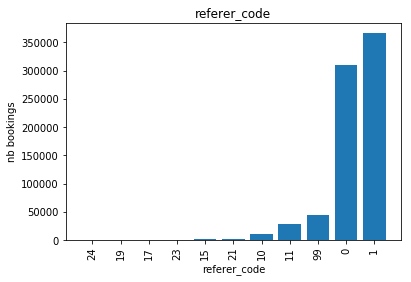


referer code, number of bookings
24, 0
19, 0
17, 21
23, 402
15, 1297
21, 1785
10, 10611
11, 29141
99, 43789
0, 309364
1, 366608


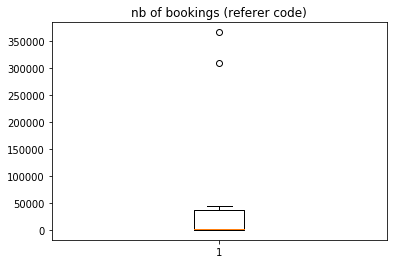

In [100]:
# referer_code: Encoded category of the referer to the website

# dict_referer_code, referer_code_list = get_nb_bookings_dict(train_user_df, 'referer_code')
dict_referer_code_nb_bookings = read_dict_from_csv('referer_code-nb_bookings.csv')
    
dict_referer_code_nb_bookings = OrderedDict(sorted(dict_referer_code_nb_bookings.items(), key=lambda x: x[1]))

plot_dict(dict_referer_code_nb_bookings, 'referer_code', 'referer_code', 'nb bookings')

#plot_dict(dict_feature_nb_bookings['referer_code'], 'referer_code', 'referer_code', 'nb bookings')

print('\nreferer code, number of bookings')
for key, value in dict_referer_code_nb_bookings.items():
    print('{}, {}'.format(key, value))
    
plt.boxplot(list(dict_referer_code_nb_bookings.values()))
plt.title('nb of bookings (referer code)')
plt.show()
    
# Users with the referer code 1 have the largest number of bookings
# Users with the referer code 24, 21 have no bookings.

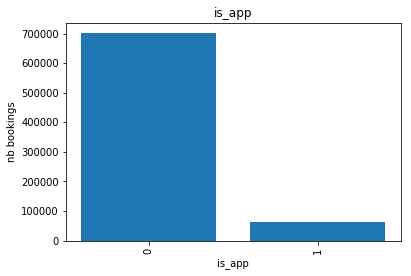


is app, number of bookings
0, 700728
1, 62290


In [101]:
# is_app: If the session was made using the trivago app

dict_is_app_nb_bookings = read_dict_from_csv('is_app-nb_bookings.csv')

plot_dict(dict_is_app_nb_bookings, 'is_app', 'is_app', 'nb bookings')
#plot_dict(dict_feature_nb_bookings['is_app'], 'is_app', 'is_app', 'nb bookings')

print('\nis app, number of bookings')
for key, value in dict_is_app_nb_bookings.items():
    print('{}, {}'.format(key, value))
    
# Most of the bookings were not made using the trivago app.


agent id, number of bookings
4, 0
5, 0
3, 8
12, 712
11, 1355
0, 2848
13, 22603
2, 33837
14, 41526
6, 57113
7, 69730
10, 78506
8, 100915
9, 128797
1, 225068


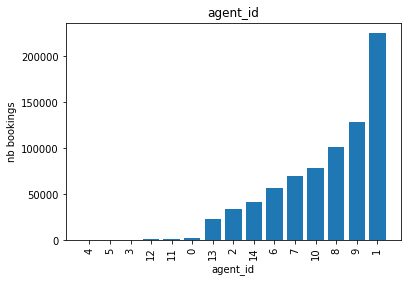

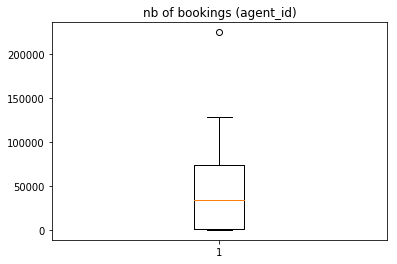

In [102]:
# agent_id: Encoded type of the browser

dict_agend_id_nb_bookings = read_dict_from_csv('agent_id-nb_bookings.csv')
    
dict_agend_id_nb_bookings = OrderedDict(sorted(dict_agend_id_nb_bookings.items(), key=lambda x: x[1]))

print('\nagent id, number of bookings')
for key, value in dict_agend_id_nb_bookings.items():
    print('{}, {}'.format(key, value))
    
plot_dict(dict_agend_id_nb_bookings, 'agent_id', 'agent_id', 'nb bookings')

# plot_dict(dict_feature_nb_bookings['agent_id'], 'agent_id', 'agent_id', 'nb bookings')

plt.boxplot(list(dict_agend_id_nb_bookings.values()))
plt.title('nb of bookings (agent_id)')
plt.show()

# We can see that agent_id has the largest number of bookings

traffic type, number of bookings
7, 56
10, 404
4, 4504
6, 35121
3, 42193
2, 172942
1, 507798


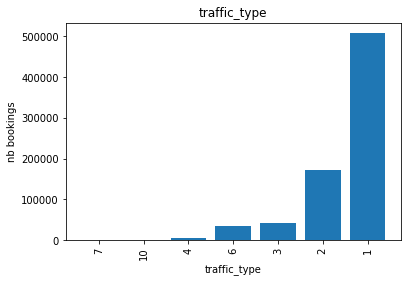

max number of bookings (traffic type): 507798
min number of bookings (traffic type): 56
mean number of bookings (traffic type): 109002.57142857143
standar deviation number of bookings (traffic type): 172225.35335994867


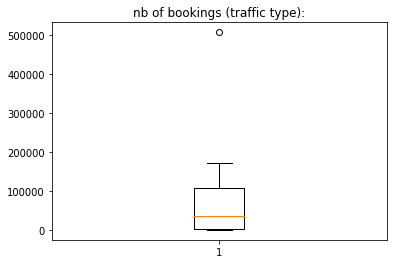

In [103]:
# traffic_type: A categorization of the type of the traffic

dict_traffic_type_nb_bookings = read_dict_from_csv('traffic_type-nb_bookings.csv')
    
dict_traffic_type_nb_bookings = OrderedDict(sorted(dict_traffic_type_nb_bookings.items(), key=lambda x: x[1]))

print('traffic type, number of bookings')
for key, value in dict_traffic_type_nb_bookings.items():
    print('{}, {}'.format(key, value))
    
plot_dict(dict_traffic_type_nb_bookings, 'traffic_type', 'traffic_type', 'nb bookings')

# plot_dict(dict_feature_nb_bookings['traffic_type'], 'traffic_type', 'traffic_type', 'nb bookings')

print('max number of bookings (traffic type): {}'.format(np.max(list(dict_traffic_type_nb_bookings.values()))))
print('min number of bookings (traffic type): {}'.format(np.min(list(dict_traffic_type_nb_bookings.values()))))
print('mean number of bookings (traffic type): {}'.format(np.mean(list(dict_traffic_type_nb_bookings.values()))))
print('standar deviation number of bookings (traffic type): {}'.format(np.std(list(dict_traffic_type_nb_bookings.values()))))

plt.boxplot(list(dict_traffic_type_nb_bookings.values()))
plt.title('nb of bookings (traffic type):')
plt.show()

# We can see the first category of traffic type 1 has the largest number of bookings

number of action id 211


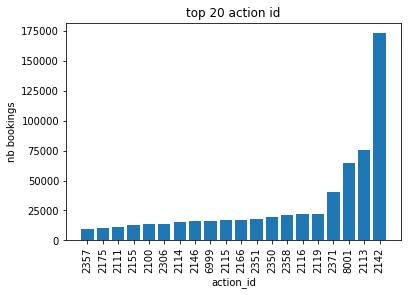

max number of bookings (action id) 173073
min number of bookings (action id) 0
mean number of bookings (action id) 3616.1990521327016
standar deviation number of bookings (action id) 14372.75768847971


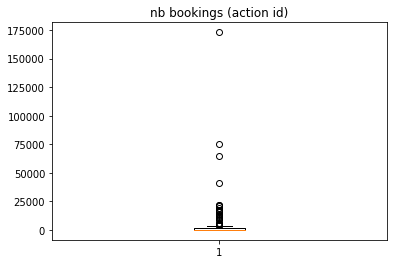

In [104]:
# action_id: Type of the action

dict_action_id_nb_bookings = read_dict_from_csv('action_id-nb_bookings.csv')
    
dict_action_id_nb_bookings = OrderedDict(sorted(dict_action_id_nb_bookings.items(), key=lambda x: x[1]))

print('number of action id {}'.format(len(list(dict_action_id_nb_bookings.keys()))))

dict_action_id_nb_bookings_top = {}

key_list = list(dict_action_id_nb_bookings.keys())[-20:]
for key in key_list:
    dict_action_id_nb_bookings_top[key] = dict_action_id_nb_bookings[key]
    
plot_dict(dict_action_id_nb_bookings_top, 'top 20 action id', 'action_id', 'nb bookings')

action_id_nb_booking_list = list(dict_action_id_nb_bookings.values())
print('max number of bookings (action id) {}'.format(np.max(action_id_nb_booking_list)))
print('min number of bookings (action id) {}'.format(np.min(action_id_nb_booking_list)))
print('mean number of bookings (action id) {}'.format(np.mean(action_id_nb_booking_list)))
print('standar deviation number of bookings (action id) {}'.format(np.std(action_id_nb_booking_list)))
#plot_dict(dict_feature_nb_bookings['action_id'], 'action_id', 'action_id', 'nb bookings')

plt.boxplot(action_id_nb_booking_list)
plt.title('nb bookings (action id)')
plt.show()

number of references 121529


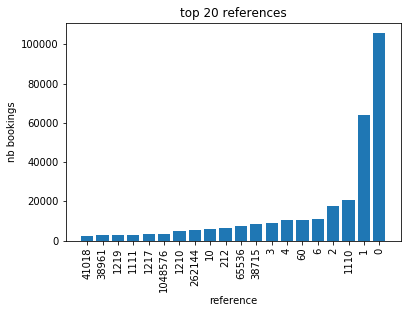

max number of bookings (reference) 105519:
min number of bookings (reference) 2532:
mean number of bookings (reference) 15205.75:
standar deviation number of bookings (reference) 24555.59740033828:


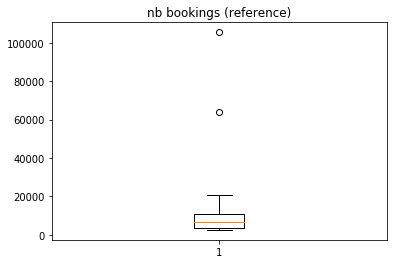

In [105]:
# reference: Object of the action. 
# - We note that action_ids with big set of reference values (e.g. action id '2116') are typically related to 
# the content (e.g hotels, destinations or keywords); while action_ids with small reference set (e.g. action id '2351') are more related a function of the website (e.g. sorting order, room type, filters, etc.)
    
dict_reference_nb_bookings = read_dict_from_csv('reference-nb_bookings.csv')
    
dict_reference_nb_bookings = OrderedDict(sorted(dict_reference_nb_bookings.items(), key=lambda x: x[1]))

print('number of references {}'.format(len(list(dict_reference_nb_bookings.keys()))))

dict_reference_nb_bookings_top = {}

key_list = list(dict_reference_nb_bookings.keys())[-20:]
for key in key_list:
    dict_reference_nb_bookings_top[key] = dict_reference_nb_bookings[key]
    
plot_dict(dict_reference_nb_bookings_top, 'top 20 references', 'reference', 'nb bookings')

reference_nb_booking_list = list(dict_reference_nb_bookings_top.values())
print('max number of bookings (reference) {}:'.format(np.max(reference_nb_booking_list)))
print('min number of bookings (reference) {}:'.format(np.min(reference_nb_booking_list)))
print('mean number of bookings (reference) {}:'.format(np.mean(reference_nb_booking_list)))
print('standar deviation number of bookings (reference) {}:'.format(np.std(reference_nb_booking_list)))
#plot_dict(dict_feature_nb_bookings['action_id'], 'action_id', 'action_id', 'nb bookings')

plt.boxplot(reference_nb_booking_list)
plt.title('nb bookings (reference)')
plt.show()

# plot_dict(dict_feature_nb_bookings['reference'], 'reference', 'reference', 'nb bookings')


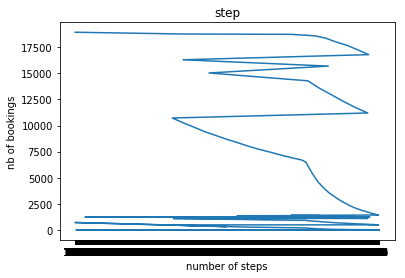

max number of bookings (step) 18936
min number of bookings (step) 0
mean number of bookings (step) 243.46458200382898
standar deviation number of bookings (step) 1417.644272898756


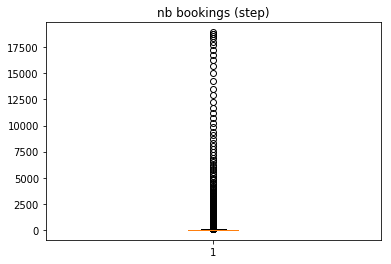

In [106]:
# step: The number identifying the action in the session
    
# print(target_user_df['step'].unique())

dict_step_nb_bookings = read_dict_from_csv('step-nb_bookings.csv')

plt.plot(list(dict_step_nb_bookings.keys()), list(dict_step_nb_bookings.values()))
plt.title('step')
plt.xlabel('number of steps')
plt.ylabel('nb of bookings')
plt.show()
# plot_dict(dict_step_nb_bookings, 'step', 'number of step', 'nb bookings')

# plot_dict(dict_feature_nb_bookings['step'], 'step', 'step', 'nb bookings')

step_nb_booking_list = list(dict_step_nb_bookings.values())
print('max number of bookings (step) {}'.format(np.max(step_nb_booking_list)))
print('min number of bookings (step) {}'.format(np.min(step_nb_booking_list)))
print('mean number of bookings (step) {}'.format(np.mean(step_nb_booking_list)))
print('standar deviation number of bookings (step) {}'.format(np.std(step_nb_booking_list)))

plt.boxplot(step_nb_booking_list)
plt.title('nb bookings (step)')
plt.show()

# It shows more steps less number of bookings.

## Step 2: Train machine learning models


### First approach

First, I use all the features of the current steps, i.e., 
feature_columns = ['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference', 'step']. 

Note: although I find that 8062/23402 users in the target set can be found in the train set, I doubt taking 'user_id' as features overfits the model. Therefore, user_id is not used to train the model.

In [13]:
# define the machine learning model

def timer(start_time=None):
    # fork from https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        
        
def train_xgb(X_train, Y_train, hyperparameter_tuning=False, model_path=None, n_jobs=4, folds=3, 
              param_comb=5, n_estimators=100):
    """
    train a xgb model

    Reference
    https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
    """
    # xgb_clf = XGBClassifier(learning_rate=0.01,
    #                     n_estimators=200,
    #                     objective='binary:logistic',
    #                     silent=True, nthread=nthread)

    print('\n === train a xgb model === \n')

    xgb_clf = XGBClassifier(n_estimators=n_estimators, nthread=n_jobs, objective='binary:logistic', silent=True,)

    if hyperparameter_tuning:
        print('xgb hyperparameter tuning ...')

        params = {
            'n_estimators': [5, 10, 80, 100, 200],
            'min_child_weight': [1, 5, 10],
            # 'gamma': [0.5, 1, 1.5, 2, 5],
            'gamma': [0.5, 1, 1.5, 2],
            # 'subsample': [0.6, 0.8, 1.0],
            'subsample': [0.6, 0.8, 1],
            # 'colsample_bytree': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1],
            # 'max_depth': [3, 4, 5]
            'max_depth': [2, 4, 6],
        }

        skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

        random_search = RandomizedSearchCV(xgb_clf, param_distributions=params, n_iter=param_comb, scoring='roc_auc',
                                           n_jobs=n_jobs,
                                           cv=skf.split(X_train, Y_train),
                                           verbose=3, random_state=42)

        start_time = timer(None)
        random_search.fit(X_train, Y_train)
        timer(start_time)

        print('--------------')
        print('\n all results:')
        print(random_search.cv_results_)

        print('\n best estimator:')
        print(random_search.best_estimator_)

        print('\n best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
        print(random_search.best_score_ * 2 - 1)

        print('\n best xgb hyperparameters:')
        print(random_search.best_params_)

        result_csv_path = 'xgb-random-grid-search-results.csv'
        results = pd.DataFrame(random_search.cv_results_)
        results.to_csv(result_csv_path, index=False)
        print('save xgb random search results to {}'.format(result_csv_path))
        print('--------------')

        #xgb_clf = random_search
        xgb_clf = random_search.best_estimator_
    else:
        xgb_clf.fit(train_sub_x, train_sub_y)

    if model_path is None:
        xgb_model_path = 'xgb.model'
        if hyperparameter_tuning:
            xgb_model_path = 'xgb.ht.model'
    else:
        xgb_model_path = model_path
        # xgb_clf.save_model(xgb_model_path)
    joblib.dump(xgb_clf, xgb_model_path)
    print('\n save the xgb model to {}'.format(xgb_model_path))

    return xgb_clf, xgb_model_path


def train_rf(X_train, Y_train, hyperparameter_tuning=False, model_path=None, n_jobs=4, folds=3, n_estimators=100):
    """
    train a RF classifier

    Reference
    https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    """
    print('\n === train a random forest model === \n')

    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=n_jobs)

    if hyperparameter_tuning:
        # Number of trees in random forest
        #n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
        n_estimators = [5, 10, 80, 100, 200]
        # Number of features to consider at every split
        max_features = ['auto', 'sqrt']
        # Maximum number of levels in tree
        #max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
        max_depth = [4, 6, 8]
        max_depth.append(None)
        # Minimum number of samples required to split a node
        min_samples_split = [2, 5, 10]
        # Minimum number of samples required at each leaf node
        min_samples_leaf = [1, 2, 4]
        # Method of selecting samples for training each tree
        bootstrap = [True, False]
        # Create the random grid
        random_grid = {'n_estimators': n_estimators,
                       'max_features': max_features,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'bootstrap': bootstrap}
        #print(random_grid)

        rf_random = RandomizedSearchCV(estimator=model, param_distributions=random_grid,
                                       n_iter=100, cv=folds, verbose=2, random_state=42, n_jobs=n_jobs)

        rf_random.fit(X_train, X_train)

        print('--------------')
        print('\n all results:')
        print(rf_random.cv_results_)

        print('\n best estimator:')
        print(rf_random.best_estimator_)

        print('\n best rf parameters:')
        print(rf_random.best_params_)

        print('\n best scores:')
        rf_random.best_score_

        result_cv_path = 'rf-random-grid-search-results.csv'
        results = pd.DataFrame(rf_random.cv_results_)
        results.to_csv(result_cv_path, index=False)
        print('\n save rf random search results to {}'.format(result_cv_path))
        print('--------------')

        model = rf_random.best_estimator_
    else:
        model.fit(X_train, Y_train)

    if model_path is None:
        model_path = 'rf.model'
        if hyperparameter_tuning:
            model_path = 'rf.ht.model'

    joblib.dump(model, model_path)
    print('\n save the rf model to {}'.format(model_path))

    return model, model_path


def train_nb(X_train, Y_train, model_path=None):
    """
    train a naive bayes classifier
    """
    # reference https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/

    print('\n === train a gaussian naive bayes model === \n')

    model = GaussianNB()
    model.fit(X_train, Y_train,)

    if model_path is None:
        model_path = 'nb.model'

    joblib.dump(model, model_path)
    print('\n save the GaussianNB model to {}'.format(model_path))

    return model, model_path


def train_lgbm(X_train, Y_train,
               categorical_feature=['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference'],
               model_path=None, n_jobs=4, hyperparameter_tuning=False, num_boost_round=100, folds=3):
    """
    train a lightGBM model

    Reference
    https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/advanced_example.py
    https://www.kaggle.com/garethjns/microsoft-lightgbm-with-parameter-tuning-0-823?scriptVersionId=1751960
    """

    print('\n === train a lightGBM === \n')

    d_train = lgb.Dataset(X_train, label=Y_train,
                          # categorical_feature=['aisle_id', 'department_id']
                          categorical_feature=categorical_feature,
                          )

    if not hyperparameter_tuning:
        params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'num_class': 1,                # must be 1 for non-multiclass training
            'metric': 'binary_error',
            #'metric': 'binary_logloss',
            #'n_jobs': n_jobs,
            'nthread': n_jobs,
            'num_leaves': 31,
            #'num_leaves': 64,
            'min_child_weight': 1,
            'min_child_samples': 5,
            'scale_pos_weight': 1,
            'reg_alpha': 5,
            'learning_rate': 0.05,
            'max_bin': 512,
            #'feature_fraction': 0.9,
            #'bagging_fraction': 0.8,
            #'bagging_freq': 5,
            #'verbose': 0
        }

        gbm = lgb.train(params,
                        d_train,
                        num_boost_round=num_boost_round,
                        categorical_feature=categorical_feature)

    else:
        params = {'boosting_type': 'gbdt',
                  'max_depth': -1,
                  'objective': 'binary',
                  'nthread': n_jobs,  # Updated from nthread
                  'num_leaves': 64,
                  'learning_rate': 0.05,
                  'max_bin': 512,
                  'subsample_for_bin': 200,
                  'subsample': 1,
                  'subsample_freq': 1,
                  'colsample_bytree': 0.8,
                  'reg_alpha': 5,
                  'reg_lambda': 10,
                  'min_split_gain': 0.5,
                  'min_child_weight': 1,
                  'min_child_samples': 5,
                  'scale_pos_weight': 1,
                  'num_class': 1,
                  'metric': 'binary_error'}

        gridParams = {
            'learning_rate': [0.005],
            'n_estimators': [8, 16, 24],
            'num_leaves': [6, 8, 12, 16],
            'boosting_type': ['gbdt'],
            'objective': ['binary'],
            'random_state': [42],  # Updated from 'seed'
            'colsample_bytree': [0.64, 0.65, 0.66],
            'subsample': [0.7, 0.75],
            'reg_alpha': [1, 1.2],
            'reg_lambda': [1, 1.2, 1.4],
        }

        mdl = lgb.LGBMClassifier(boosting_type='gbdt',
                                 objective='binary',
                                 n_jobs=n_jobs,  # Updated from 'nthread'
                                 silent=True,
                                 max_depth=params['max_depth'],
                                 max_bin=params['max_bin'],
                                 subsample_for_bin=params['subsample_for_bin'],
                                 subsample=params['subsample'],
                                 subsample_freq=params['subsample_freq'],
                                 min_split_gain=params['min_split_gain'],
                                 min_child_weight=params['min_child_weight'],
                                 min_child_samples=params['min_child_samples'],
                                 scale_pos_weight=params['scale_pos_weight'])

        print(mdl.get_params().keys())

        grid = RandomizedSearchCV(estimator=mdl, param_distributions=gridParams,
                                       n_iter=100, cv=folds, verbose=2, random_state=42, n_jobs=n_jobs)

        #grid = GridSearchCV(mdl, gridParams, verbose=2, cv=folds, n_jobs=n_jobs)
        grid.fit(X_train, Y_train)

        print('best parameters:')
        print(grid.best_params_)
        print('best score: ')
        print(grid.best_score_)

        # using parameters already set above, replace in the best from the grid search
        params['colsample_bytree'] = grid.best_params_['colsample_bytree']
        params['learning_rate'] = grid.best_params_['learning_rate']
        #params['max_bin'] = grid.best_params_['max_bin']
        params['num_leaves'] = grid.best_params_['num_leaves']
        params['reg_alpha'] = grid.best_params_['reg_alpha']
        params['reg_lambda'] = grid.best_params_['reg_lambda']
        params['subsample'] = grid.best_params_['subsample']
        #params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']

        print('Fitting with params: ')
        print(params)

        X_train_sub, X_val, Y_train_sub, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

        d_train_sub = lgb.Dataset(X_train_sub, label=Y_train_sub,
                              # categorical_feature=['aisle_id', 'department_id']
                              categorical_feature=categorical_feature,
                              #categorical_feature='auto'
                              )

        d_val_sub = lgb.Dataset(X_val, label=Y_val,
                              # categorical_feature=['aisle_id', 'department_id']
                              categorical_feature=categorical_feature,
                              #categorical_feature='auto'
                              )

        gbm = lgb.train(params,
                        d_train_sub,
                        num_boost_round=1000,
                        valid_sets=[d_train_sub, d_val_sub],
                        early_stopping_rounds=50,
                        verbose_eval=4)

        # Plot importance
        #lgb.plot_importance(gbm)

    if model_path is None:
        model_path = 'lgbm.model'
        if hyperparameter_tuning:
            model_path = 'lgbm.ht.model'

    # save model to file
    gbm.save_model(model_path)
    print('\n save the lightGBM model to {}'.format(model_path))

    # load model to predict
    # print('Load model to predict')
    # bst = lgb.Booster(model_file='model.txt')
    # can only predict with the best iteration (or the saving iteration)
    # y_pred = bst.predict(X_test)

    return gbm, model_path


def train_catboost(X_train, Y_train,
                   categorical_feature=[0, 1, 2, 3, 4, 5],
                   #categorical_feature=['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference'],
                   model_path=None, hyperparameter_tuning=False, num_boost_round=100):
    """
    train a catboost model

    Reference:
    https://tech.yandex.com/catboost/doc/dg/concepts/python-usages-examples-docpage/
    """

    print('\n === train a catboost === \n')

    model = CatBoostClassifier(loss_function='Logloss',
                               iterations=num_boost_round,
                               #learning_rate=1,
                               #depth=2
                               )
    model.fit(X_train, Y_train, categorical_feature)

    if model_path is None:
        model_path = 'catboost.model'
        if hyperparameter_tuning:
            model_path = 'catboost.ht.model'

    model.save_model(model_path)

    print('\n save the catboost model to {}'.format(model_path))

    return model, model_path


def predict(model_path, X_test, is_lgbm=False, is_catboost=False, lgbm_threshold=0.5):
    """
    load the model and predict unseen data
    """

    print('\n === predict === \n')

    if is_lgbm:
        # lightgbm
        model = lgb.Booster(model_file=model_path)
    elif is_catboost:
        model = CatBoostClassifier()
        model = model.load_model(model_path)
    else:
        # sklearn
        # xgboost
        model = joblib.load(model_path)

    # y_pred = model.predict_prob(X_test)
    y_pred = model.predict(X_test)

    if is_lgbm:
        #print('==')
        #print(y_pred)
        y_output = []
        for y in y_pred:
            if y > lgbm_threshold:
                y_output.append(1)
            else:
                y_output.append(0)
        #print('==')
        #print(y_output)
        return(np.array(y_output))
        #return np.array([np.argmax(y) for y in y_pred])
    else:
        return y_pred
    

def blend_predictions(y_pred_list, threshold=0.7):
    """
    blend the predictions
    """

    print('\n === blend predictions === \n')

    y_pred = y_pred_list[0]

    for i in range(1, len(y_pred_list)):
        for j in range(len(y_pred)):
            y_pred[j] += y_pred_list[i][j]

    y_pred = y_pred*1.0 / len(y_pred_list)

    y_output = []
    for y in y_pred:
        if y > threshold:
            y_output.append(1)
        else:
            y_output.append(0)

    return np.array(y_output)


In [14]:
feature_columns = ['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference', 'step']
target_column   = ['has_booking']

# define the data preparation functions

def preprocessing(df):
    print('\n === preprocess data === \n')

    df['action_id'].fillna(NA_ACTION_ID, inplace=True)
    df['reference'].fillna(NA_REFERENCE_ID, inplace=True)
    df['step'].fillna(NA_STEP, inplace=True)

    df['referer_code'] = df['referer_code'].astype('int')
    df['is_app'] = df['is_app'].astype('int')
    df['agent_id'] = df['agent_id'].astype('int')
    df['traffic_type'] = df['traffic_type'].astype('int')
    df['action_id'] = df['action_id'].astype('int')
    df['reference'] = df['reference'].astype('int')
    df['step'] = df['step'].astype('int')

    if 'has_booking' in df.columns:
        df['has_booking'] = df['has_booking'].astype('int')

    return df

def get_train_set(df, feature_columns):
    print('\n === get train set === \n')

    train_df = df[feature_columns + target_column]

    train_x = train_df[feature_columns]
    train_y = train_df[target_column].values

    # https://stackoverflow.com/questions/31995175/scikit-learn-cross-val-score-too-many-indices-for-array
    """
    When we do cross validation in scikit-learn, the process requires an (R,) shape label instead of (R,1). 
    Although they are the same thing to some extend, their indexing mechanisms are different. So in your case, just add:
    c, r = labels.shape
    labels = labels.reshape(c,)
    """
    c, r = train_y.shape
    train_y = train_y.reshape(c, )

    return train_x, train_y

def get_test_set(df, feature_columns):
    print('\n === get test set === \n')

    test_x = df[feature_columns]

    return test_x

In [15]:
# define the evaluation function

def evaluate(y_true, y_pred):
    """
    evaluate the predictions
    """
    print('\n === evaluate === \n')

    nb_bookings_true = 0
    for y in y_true:
        if y == 1:
            nb_bookings_true += 1
    print('\n number of bookings in y_true: {}'.format(nb_bookings_true))
    print('\n y_true shape:')
    print(y_true.shape)

    nb_bookings_pred = 0
    for y in y_pred:
        if y == 1:
            nb_bookings_pred += 1
    print('\n number of bookings in y_pred {}'.format(nb_bookings_pred))
    print('\n y_pred shape:')
    print(y_pred.shape)

    mcc_score = matthews_corrcoef(y_true, y_pred)
    print('\n matthews corrcoef score {}'.format(mcc_score))

    """
      tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
      print(tn)
      print(fp)
      print(fn)
      print(tp)
      print('---')

      mcc = (tp*tn - fp*fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
      print(mcc)
      print(matthews_corrcoef(y_true, y_pred))
      """

    accuracy = accuracy_score(y_true, y_pred)
    print('\n accuracy: {}'.format(accuracy))
    print('\n classification report:')
    print(classification_report(y_true, y_pred))

    f1score = f1_score(y_true, y_pred, average='binary')
    print('\n f1 score: {}'.format(f1score))

    #roc_auc_score(y_true, y_pred)

    return mcc_score, accuracy, f1score

In [16]:

# ---
# Define file paths
TRAIN_BOOKING_FILE_PATH = 'data/case_study_bookings_train.csv'    # training sessions for bookings
TARGET_BOOKING_FILE_PATH = 'data/case_study_bookings_target.csv'  # target sessions to predict bookings

TRAIN_ACTION_FILE_PATH = 'data/case_study_actions_train.csv'       # training set of user actions
TARGET_ACTION_FILE_PATH = 'data/case_study_actions_target.csv'     # user actions in the target sessions

# replace the NAN values by a specific value
NA_ACTION_ID = -10
NA_REFERENCE_ID = -10
NA_STEP = 0

# -------------------
# read the data
train_booking_df = pd.read_csv(TRAIN_BOOKING_FILE_PATH, sep='\t')
train_booking_df['ymd'] = pd.to_datetime(train_booking_df['ymd'].astype('str'))

target_booking_df = pd.read_csv(TARGET_BOOKING_FILE_PATH, sep='\t')
target_booking_df['ymd'] = pd.to_datetime(target_booking_df['ymd'].astype('str'))

train_user_id_list = train_booking_df['user_id'].unique()
train_session_id_list = train_booking_df['session_id'].unique()

target_user_id_list = target_booking_df['user_id'].unique()
target_session_id_list = target_booking_df['session_id'].unique()

train_action_df = pd.read_csv(TRAIN_ACTION_FILE_PATH, sep='\t')
train_action_df['ymd'] = pd.to_datetime(train_action_df['ymd'].astype('str'))

target_action_df = pd.read_csv(TARGET_ACTION_FILE_PATH, sep='\t')
target_action_df['ymd'] = pd.to_datetime(target_action_df['ymd'].astype('str'))

train_user_df = pd.merge(train_booking_df, train_action_df, on=['ymd', 'user_id', 'session_id'], how='left')

train_user_df = preprocessing(train_user_df)

target_user_df = pd.merge(target_booking_df, target_action_df, on=['ymd', 'user_id', 'session_id'], how='left')

target_user_df = preprocessing(target_user_df)

# -------------------
# prepare train, validation, and test sets

# shuffle the train set
train_user_df = train_user_df.reindex(np.random.permutation(train_user_df.index))

train_x, train_y = get_train_set(train_user_df, feature_columns)
print('\n -----')
print('train set size:')
print(train_x.shape)
print(train_y.shape)

train_sub_x, val_x, train_sub_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print('\n -----')
print('sub train set size:')
print(train_sub_x.shape)
print(train_sub_y.shape)

print('\n -----')
print('validation set size:')
print(val_x.shape)
print(val_y.shape)

test_x = get_test_set(target_user_df, feature_columns)
print('\n -----')
print('test set size:')
print(test_x.shape)
# print(test_y.shape)



 === preprocess data === 


 === preprocess data === 


 === get train set === 


 -----
train set size:
(5864434, 7)
(5864434,)

 -----
sub train set size:
(4691547, 7)
(4691547,)

 -----
validation set size:
(1172887, 7)
(1172887,)

 === get test set === 


 -----
test set size:
(575323, 7)


In [17]:
def plot_performance(x_list, y_list, title, x_label, y_label):
    """
    define the plotting function
    """
    plt.plot(x_list, y_list)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [18]:
approach = 1   # first approach
hyperparameter_tuning = False

In [ ]:
# --------
# catboost performance evaluation on the validation set
#
print('=== catboost experiments ===')

num_boost_round_list = [10, 50, 100, 150, 200, 300]

# key: num_boost_round  value: score
mcc_catboost_list = []
acc_catboost_list = []
f1_catboost_list = []

for num_boost_round in num_boost_round_list:
    print('\nnum_boost_round: {}'.format(num_boost_round))
    
    model_path = 'catboost-[approach]{}-[num_boost_round]{}-[ht]{}.model'.format(approach, 
                                                                                 num_boost_round, 
                                                                                 hyperparameter_tuning)
    
    model, model_path = train_catboost(train_sub_x, train_sub_y, hyperparameter_tuning=hyperparameter_tuning, 
                                       model_path=model_path, num_boost_round=num_boost_round)
    
    y_pred = predict(model_path=model_path, X_test=val_x, is_catboost=True)
    
    mcc_score, accuracy, f1score = evaluate(val_y, y_pred)
    
    mcc_catboost_list.append(mcc_score)
    acc_catboost_list.append(accuracy)
    f1_catboost_list.append(f1score)
    
plot_performance(num_boost_round_list, mcc_catboost_list, 'mcc score', 'num_boost_round', 'mcc score (catboost)')
plot_performance(num_boost_round_list, acc_catboost_list, 'accuracy', 'num_boost_round', 'accuracy (catboost)')
plot_performance(num_boost_round_list, f1_catboost_list, 'f1 score', 'num_boost_round', 'f1 score (catboost)')


=== catboost experiments ===

num_boost_round: 10

 === train a catboost === 

0:	learn: 0.6695855	total: 7.57s	remaining: 1m 8s
1:	learn: 0.6476487	total: 12.3s	remaining: 49.2s
2:	learn: 0.6273903	total: 18.8s	remaining: 43.8s
3:	learn: 0.6077532	total: 24.6s	remaining: 36.9s
4:	learn: 0.5899682	total: 29.1s	remaining: 29.1s
5:	learn: 0.5738335	total: 35.5s	remaining: 23.7s
6:	learn: 0.5583713	total: 41.5s	remaining: 17.8s
7:	learn: 0.5443543	total: 47.1s	remaining: 11.8s
8:	learn: 0.5313315	total: 53s	remaining: 5.89s
9:	learn: 0.5192305	total: 59.3s	remaining: 0us

 save the catboost model to catboost-[approach]1-[num_boost_round]10-[ht]False.model

 === predict === 


 === evaluate === 


 number of bookings in y_true: 152797

 y_true shape:
(1172887,)

 number of bookings in y_pred 1099

 y_pred shape:
(1172887,)

 matthews corrcoef score 0.0634825601243236

 accuracy: 0.8703404505293348

 classification report:
             precision    recall  f1-score   support

          0   

72:	learn: 0.2820227	total: 5m 32s	remaining: 2m 2s
73:	learn: 0.2815242	total: 5m 36s	remaining: 1m 58s
74:	learn: 0.2809631	total: 5m 39s	remaining: 1m 53s
75:	learn: 0.2803145	total: 5m 43s	remaining: 1m 48s
76:	learn: 0.2798066	total: 5m 47s	remaining: 1m 43s
77:	learn: 0.2791911	total: 5m 51s	remaining: 1m 39s
78:	learn: 0.2788039	total: 5m 54s	remaining: 1m 34s
79:	learn: 0.2783407	total: 5m 58s	remaining: 1m 29s
80:	learn: 0.2778942	total: 6m 3s	remaining: 1m 25s
81:	learn: 0.2775466	total: 6m 8s	remaining: 1m 20s
82:	learn: 0.2770803	total: 6m 12s	remaining: 1m 16s
83:	learn: 0.2767454	total: 6m 18s	remaining: 1m 12s
84:	learn: 0.2764337	total: 6m 24s	remaining: 1m 7s
85:	learn: 0.2759233	total: 6m 28s	remaining: 1m 3s
86:	learn: 0.2756497	total: 6m 32s	remaining: 58.6s
87:	learn: 0.2753781	total: 6m 36s	remaining: 54s
88:	learn: 0.2750665	total: 6m 39s	remaining: 49.4s
89:	learn: 0.2748152	total: 6m 45s	remaining: 45s
90:	learn: 0.2743119	total: 6m 49s	remaining: 40.5s
91:	lea

115:	learn: 0.2672519	total: 12m 24s	remaining: 3m 38s
116:	learn: 0.2670484	total: 12m 32s	remaining: 3m 32s
117:	learn: 0.2668708	total: 12m 39s	remaining: 3m 25s
118:	learn: 0.2666409	total: 12m 49s	remaining: 3m 20s
119:	learn: 0.2665259	total: 12m 58s	remaining: 3m 14s
120:	learn: 0.2663239	total: 13m 8s	remaining: 3m 8s
121:	learn: 0.2662578	total: 13m 18s	remaining: 3m 3s
122:	learn: 0.2661388	total: 13m 25s	remaining: 2m 56s
123:	learn: 0.2658896	total: 13m 35s	remaining: 2m 51s
124:	learn: 0.2657192	total: 13m 45s	remaining: 2m 45s
125:	learn: 0.2656053	total: 13m 54s	remaining: 2m 38s
126:	learn: 0.2653045	total: 14m 1s	remaining: 2m 32s
127:	learn: 0.2652491	total: 14m 11s	remaining: 2m 26s
128:	learn: 0.2651144	total: 14m 19s	remaining: 2m 19s
129:	learn: 0.2648419	total: 14m 25s	remaining: 2m 13s
130:	learn: 0.2645625	total: 14m 33s	remaining: 2m 6s
131:	learn: 0.2644812	total: 14m 41s	remaining: 2m
132:	learn: 0.2643224	total: 14m 47s	remaining: 1m 53s
133:	learn: 0.26417

106:	learn: 0.2676677	total: 9m 54s	remaining: 8m 36s
107:	learn: 0.2673734	total: 10m 1s	remaining: 8m 32s
108:	learn: 0.2671740	total: 10m 8s	remaining: 8m 27s
109:	learn: 0.2669159	total: 10m 14s	remaining: 8m 22s
110:	learn: 0.2667799	total: 10m 20s	remaining: 8m 17s
111:	learn: 0.2663416	total: 10m 25s	remaining: 8m 11s
112:	learn: 0.2662345	total: 10m 32s	remaining: 8m 7s
113:	learn: 0.2660733	total: 10m 39s	remaining: 8m 2s
114:	learn: 0.2658821	total: 10m 45s	remaining: 7m 56s
115:	learn: 0.2656717	total: 10m 52s	remaining: 7m 52s
116:	learn: 0.2654687	total: 11m	remaining: 7m 48s
117:	learn: 0.2653490	total: 11m 8s	remaining: 7m 44s
118:	learn: 0.2653182	total: 11m 15s	remaining: 7m 40s
119:	learn: 0.2651609	total: 11m 20s	remaining: 7m 33s
120:	learn: 0.2648745	total: 11m 24s	remaining: 7m 27s
121:	learn: 0.2647727	total: 11m 31s	remaining: 7m 21s
122:	learn: 0.2645788	total: 11m 39s	remaining: 7m 17s
123:	learn: 0.2644122	total: 11m 46s	remaining: 7m 13s
124:	learn: 0.264224

In [ ]:
# --------
# xgboost performance evaluation on the validation set
#
print('=== xgboost experiments ===')

num_boost_round_list = [10, 50, 100, 150, 200]

# key: num_boost_round  value: score
mcc_xgb_list = []
acc_xgb_list = []
f1_xgb_list  = []

for num_boost_round in num_boost_round_list:
    print('\nnum_boost_round: {}'.format(num_boost_round))
    
    model_path = 'xgb-[approach]{}-[num_boost_round]{}-[ht]{}.model'.format(approach, 
                                                                            num_boost_round,
                                                                            hyperparameter_tuning)
    
    model, model_path = train_xgb(train_sub_x, train_sub_y, hyperparameter_tuning=hyperparameter_tuning, 
                                       model_path=model_path, num_boost_round=num_boost_round)
    
    y_pred = predict(model_path=model_path, X_test=val_x)
    
    mcc_score, accuracy, f1score = evaluate(val_y, y_pred)
    
    mcc_xgb_list.append(mcc_score)
    acc_xgb_list.append(accuracy)
    f1_xgb_list.append(f1score)
    
plot_performance(num_boost_round_list, mcc_xgb_list, 'mcc score', 'num_boost_round', 'mcc score (xgboost)')
plot_performance(num_boost_round_list, acc_xgb_list, 'accuracy', 'num_boost_round', 'accuracy (xgboost)')
plot_performance(num_boost_round_list, f1_xgb_list, 'f1 score', 'num_boost_round', 'f1 score (xgboost)')

In [ ]:
# --------
# lightGBM performance evaluation on the validation set
#
print('=== lightGBM experiments ===')

num_boost_round_list = [10, 50, 100, 150, 200]

# key: num_boost_round  value: score
mcc_lgb_list = []
acc_lgb_list = []
f1_lgb_list = []

for num_boost_round in num_boost_round_list:
    print('\nnum_boost_round: {}'.format(num_boost_round))
    
    model_path = 'lgb-[approach]{}-[num_boost_round]{}-[ht]{}.model'.format(approach, 
                                                                            num_boost_round,
                                                                            hyperparameter_tuning)
    
    model, model_path = train_lgbm(train_sub_x, train_sub_y, hyperparameter_tuning=hyperparameter_tuning, 
                                       model_path=model_path, num_boost_round=num_boost_round)
    
    y_pred = predict(model_path=model_path, X_test=val_x)
    
    mcc_score, accuracy, f1score = evaluate(val_y, y_pred)
    
    mcc_lgb_list.append(mcc_score)
    acc_lgb_list.append(accuracy)
    f1_lgb_list.append(f1score)
    
plot_performance(num_boost_round_list, mcc_lgb_list, 'mcc score', 'num_boost_round', 'mcc score (lightGBM)')
plot_performance(num_boost_round_list, acc_lgb_list, 'accuracy', 'num_boost_round', 'accuracy (lightGBM)')
plot_performance(num_boost_round_list, f1_lgb_list, 'f1 score', 'num_boost_round', 'f1 score (lightGBM)')

In [ ]:
# --------
# random forest performance evaluation on the validation set
#
print('=== random forest experiments ===')

n_estimators_list = [10, 50, 100, 150, 200]

# key: n_estimators  value: score
mcc_rf_list = []
acc_rf_list = []
f1_rf_list = []

for n_estimators in n_estimators_list:
    print('\nn_estimators: {}'.format(n_estimators))
    
    model_path = 'rf-{}.model'.format(n_estimators)
    
    model_path = 'rf-[approach]{}-[n_estimators]{}-[ht]{}.model'.format(approach,
                                                                        n_estimators,
                                                                        hyperparameter_tuning)
    
    model, model_path = train_rf(train_sub_x, train_sub_y, hyperparameter_tuning=hyperparameter_tuning, 
                                 model_path=model_path, n_estimators=n_estimators)
    
    y_pred = predict(model_path=model_path, X_test=val_x)
    
    mcc_score, accuracy, f1score = evaluate(val_y, y_pred)
    
    mcc_rf_list.append(mcc_score)
    acc_rf_list.append(accuracy)
    f1_rf_list.append(f1score)
    
plot_performance(num_boost_round_list, mcc_lgb_list, 'mcc score', 'num_boost_round', 'mcc score (rf)')
plot_performance(num_boost_round_list, acc_lgb_list, 'accuracy', 'num_boost_round', 'accuracy (rf)')
plot_performance(num_boost_round_list, f1_lgb_list, 'f1 score', 'num_boost_round', 'f1 score (rf)')

In [ ]:
# --------
# naive bayes classifier performance evaluation on the validation set
#
print('=== navie bayes experiments ===')

mcc_nb = 0
acc_nb = 0
f1_nb = 0

model_path = 'nb.model'
    
model, model_path = train_nb(train_sub_x, train_sub_y, model_path=model_path)
    
y_pred = predict(model_path=model_path, X_test=val_x)
    
mcc_nb, acc_nb, f1_nb = evaluate(val_y, y_pred)
    
print('mcc (nb): {}'.format(mcc_nb))
print('acc (nb): {}'.format(acc_nb))
print('f1 score (nb): {}'.format(f1_nb))


### Second approach

In this approach, the action information (i.e., action_id, reference) of the previous steps is considered as features.
For each session, at each n steps, the m previous steps action information will be considered as features.
n and m are two hyperparameters. With small n (e.g., 1) and large m, we will get better performance. However, due to the large amount of sessions (i.e., more than 300k) and the limitation of my current computation resource, I am not able to set n to 1 and m to a very large number.